In [22]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

In [23]:
class SentimentAnalyser:
    def __init__(self):
        # Initialize necessary NLTK downloads
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
            
        try:
            nltk.data.find('corpora/stopwords')
        except LookupError:
            nltk.download('stopwords')
            
        try:
            nltk.data.find('corpora/wordnet')
        except LookupError:
            nltk.download('wordnet')
            
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.vectorizer = None
        self.model = None
        
    def preprocess_text(self, text):
        """Clean and preprocess text data"""
        # Handle NaN values
        if pd.isna(text):
            return ""
            
        # Convert to string if needed
        text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = nltk.word_tokenize(text)
        
        # Remove stopwords and lemmatize
        processed_tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words and len(word) > 2]
        
        # Join tokens back into a string
        return ' '.join(processed_tokens)
    
    def prepare_kaggle_data(self, train_path, test_path=None):
        """Load and prepare data from Kaggle dataset with encoding handling"""
        # Load training data
        print("Loading training dataset...")
        try:
            # Try different encodings
            encodings_to_try = ['latin1', 'ISO-8859-1', 'cp1252']
            
            for encoding in encodings_to_try:
                try:
                    print(f"Trying to read with {encoding} encoding...")
                    train_data = pd.read_csv(train_path, encoding=encoding)
                    break
                except UnicodeDecodeError:
                    continue
            else:
                raise ValueError("Could not read the file with any of the attempted encodings")
            
            # Check if required columns exist
            if 'text' not in train_data.columns or 'sentiment' not in train_data.columns:
                raise ValueError("Dataset must contain 'text' and 'sentiment' columns")
            
            # Preprocess text
            print("Preprocessing training text data...")
            train_data['processed_text'] = train_data['text'].apply(self.preprocess_text)
            
            # Encode sentiment
            print("Encoding sentiment labels...")
            sentiment_mapping = {
                'positive': 2, 
                'neutral': 1, 
                'negative': 0
            }
            train_data['sentiment_encoded'] = train_data['sentiment'].map(sentiment_mapping)
            
            # Load test data if provided
            if test_path:
                print("Loading test dataset...")
                for encoding in encodings_to_try:
                    try:
                        print(f"Trying to read test file with {encoding} encoding...")
                        test_data = pd.read_csv(test_path, encoding=encoding)
                        break
                    except UnicodeDecodeError:
                        continue
                else:
                    raise ValueError("Could not read the test file with any of the attempted encodings")
                
                if 'text' not in test_data.columns or 'sentiment' not in test_data.columns:
                    raise ValueError("Test dataset must contain 'text' and 'sentiment' columns")
                
                print("Preprocessing test text data...")
                test_data['processed_text'] = test_data['text'].apply(self.preprocess_text)
                test_data['sentiment_encoded'] = test_data['sentiment'].map(sentiment_mapping)
                
                # Split training data
                print("Splitting data into train and validation sets...")
                X_train, X_val, y_train, y_val = train_test_split(
                    train_data['processed_text'], 
                    train_data['sentiment_encoded'],
                    test_size=0.1,
                    random_state=42
                )
                
                # Prepare test data
                X_test = test_data['processed_text']
                y_test = test_data['sentiment_encoded']
                
                return X_train, X_val, X_test, y_train, y_val, y_test
                
            else:
                # Split data into train, validation, and test sets
                print("Splitting data into train, validation, and test sets...")
                X_train, X_temp, y_train, y_temp = train_test_split(
                    train_data['processed_text'], 
                    train_data['sentiment_encoded'],
                    test_size=0.3,
                    random_state=42
                )
                
                X_val, X_test, y_val, y_test = train_test_split(
                    X_temp, 
                    y_temp,
                    test_size=0.5,
                    random_state=42
                )
                
                return X_train, X_val, X_test, y_train, y_val, y_test
            
        except Exception as e:
            print(f"Error preparing data: {e}")
            return None, None, None, None, None, None
            
    def train_model(self, X_train, y_train):
        """Train sentiment analysis model"""
        try:
            # Create TF-IDF vectorizer
            print("Creating TF-IDF features...")
            self.vectorizer = TfidfVectorizer(max_features=5000)
            X_train_tfidf = self.vectorizer.fit_transform(X_train)
            
            # Train logistic regression model
            print("Training logistic regression model...")
            self.model = LogisticRegression(C=1, max_iter=1000)
            self.model.fit(X_train_tfidf, y_train)
            
            print("Model training complete!")
            return True
            
        except Exception as e:
            print(f"Error training model: {e}")
            return False
            
    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance"""
        try:
            # Transform test data
            X_test_tfidf = self.vectorizer.transform(X_test)
            
            # Make predictions
            y_pred = self.model.predict(X_test_tfidf)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            
            # Print results
            print(f"Model Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(report)
            
            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.colorbar()
            
            classes = ['Negative', 'Neutral', 'Positive']
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
            
            # Add text annotations to confusion matrix
            thresh = cm.max() / 2
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, format(cm[i, j], 'd'),
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")
            
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
            plt.show()
            
            return accuracy, report
            
        except Exception as e:
            print(f"Error evaluating model: {e}")
            return None, None
            
    def predict_sentiment(self, text):
        """Predict sentiment for new text"""
        if self.model is None or self.vectorizer is None:
            print("Model not trained. Please train the model first.")
            return None
            
        try:
            # Preprocess the text
            processed_text = self.preprocess_text(text)
            
            # Transform using vectorizer
            text_tfidf = self.vectorizer.transform([processed_text])
            
            # Predict
            prediction = self.model.predict(text_tfidf)[0]
            probabilities = self.model.predict_proba(text_tfidf)[0]
            
            # Map numeric prediction to sentiment
            sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
            sentiment = sentiment_map[prediction]
            
            # Create result dictionary
            result = {
                'text': text,
                'sentiment': sentiment,
                'confidence': {
                    'negative': round(probabilities[0], 4),
                    'neutral': round(probabilities[1], 4) if len(probabilities) > 1 else 0,
                    'positive': round(probabilities[2], 4) if len(probabilities) > 2 else 0
                }
            }
            
            return result
            
        except Exception as e:
            print(f"Error predicting sentiment: {e}")
            return None
            
    def save_model(self, model_path='sentiment_model.pkl', vectorizer_path='vectorizer.pkl'):
        """Save trained model and vectorizer to files"""
        if self.model is None or self.vectorizer is None:
            print("Model not trained. Nothing to save.")
            return False
            
        try:
            with open(model_path, 'wb') as f:
                pickle.dump(self.model, f)
                
            with open(vectorizer_path, 'wb') as f:
                pickle.dump(self.vectorizer, f)
                
            print(f"Model saved to {model_path} and vectorizer saved to {vectorizer_path}")
            return True
            
        except Exception as e:
            print(f"Error saving model: {e}")
            return False
            
    def load_model(self, model_path='sentiment_model.pkl', vectorizer_path='vectorizer.pkl'):
        """Load trained model and vectorizer from files"""
        try:
            with open(model_path, 'rb') as f:
                self.model = pickle.load(f)
                
            with open(vectorizer_path, 'rb') as f:
                self.vectorizer = pickle.load(f)
                
            print("Model and vectorizer loaded successfully!")
            return True
            
        except Exception as e:
            print(f"Error loading model: {e}")
            return False


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Converting CSV files to UTF-8 encoding...
Conversion successful!
Loading training dataset...
Trying to read with latin1 encoding...
Preprocessing training text data...
Encoding sentiment labels...
Loading test dataset...
Trying to read test file with latin1 encoding...
Preprocessing test text data...
Splitting data into train and validation sets...
Creating TF-IDF features...
Training logistic regression model...
Model training complete!

Validation Set Evaluation:
Model Accuracy: 0.6817

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       766
           1       0.63      0.74      0.68      1130
           2       0.76      0.69      0.72       853

    accuracy                           0.68      2749
   macro avg       0.70      0.67      0.68      2749
weighted avg       0.69      0.68      0.68      2749



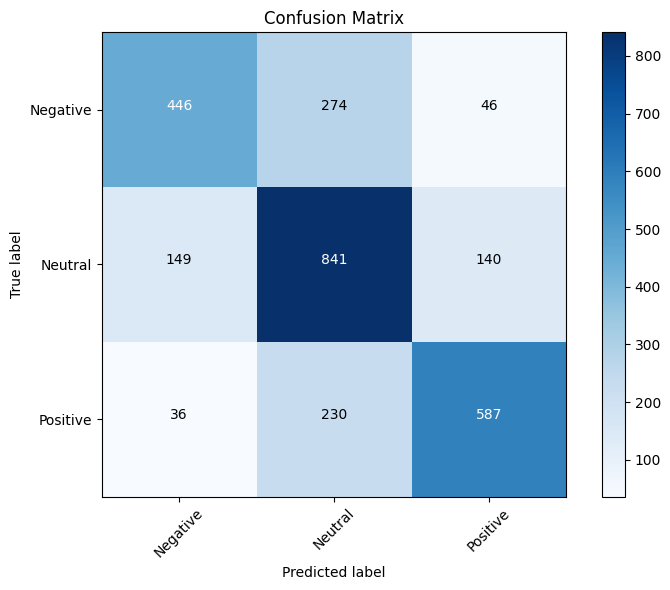


Test Set Evaluation:
Error evaluating model: Input y_true contains NaN.
Model saved to sentiment_model.pkl and vectorizer saved to vectorizer.pkl

Sentiment Analysis Results:

Text: I absolutely love this product! It works perfectly.
Sentiment: POSITIVE
Confidence: {'negative': np.float64(0.0502), 'neutral': np.float64(0.3097), 'positive': np.float64(0.64)}

Text: The service was okay, nothing special.
Sentiment: NEUTRAL
Confidence: {'negative': np.float64(0.087), 'neutral': np.float64(0.4869), 'positive': np.float64(0.4261)}

Text: This is the worst experience I've ever had. Terrible customer service.
Sentiment: NEGATIVE
Confidence: {'negative': np.float64(0.8507), 'neutral': np.float64(0.0812), 'positive': np.float64(0.0681)}

Text: I had a great time at the restaurant, the food was delicious!
Sentiment: POSITIVE
Confidence: {'negative': np.float64(0.0227), 'neutral': np.float64(0.0425), 'positive': np.float64(0.9349)}

Text: The movie was a bit boring but the actors performed well.

In [26]:
if __name__ == "__main__":
    # Create analyzer
    analyser = SentimentAnalyser()
    
    try:
        import pandas as pd
        print("Converting CSV files to UTF-8 encoding...")
        
        # Read with Latin-1 encoding
        train_data = pd.read_csv('train.csv', encoding='latin1')
        test_data = pd.read_csv('test.csv', encoding='latin1')
        
        # Save with UTF-8 encoding
        train_data.to_csv('train_utf8.csv', index=False, encoding='utf-8')
        test_data.to_csv('test_utf8.csv', index=False, encoding='utf-8')
        
        print("Conversion successful!")
        
        # Use the converted files
        train_path = 'train_utf8.csv'
        test_path = 'test_utf8.csv'
    except Exception as e:
        print(f"Error fixing encoding: {e}")
        print("Continuing with original files...")
        train_path = 'train.csv'
        test_path = 'test.csv'
    
    
    # Option 1: Use both train and test datasets
    X_train, X_val, X_test, y_train, y_val, y_test = analyser.prepare_kaggle_data(train_path, test_path)
    
    # Option 2: Use only train dataset and split it internally
    # X_train, X_val, X_test, y_train, y_val, y_test = analyzer.prepare_kaggle_data(train_path)
    
    # Check if data was loaded successfully
    if X_train is not None:
        # Train the model
        analyser.train_model(X_train, y_train)
        
        # Evaluate on validation set
        print("\nValidation Set Evaluation:")
        analyser.evaluate_model(X_val, y_val)
        
        # Evaluate on test set
        print("\nTest Set Evaluation:")
        analyser.evaluate_model(X_test, y_test)
        
        # Save the trained model
        analyser.save_model()
        
        # Test with some examples
        print("\nSentiment Analysis Results:")
        example_texts = [
            "I absolutely love this product! It works perfectly.",
            "The service was okay, nothing special.",
            "This is the worst experience I've ever had. Terrible customer service.",
            "I had a great time at the restaurant, the food was delicious!",
            "The movie was a bit boring but the actors performed well."
        ]
        
        for text in example_texts:
            result = analyser.predict_sentiment(text)
            if result:
                print(f"\nText: {result['text']}")
                print(f"Sentiment: {result['sentiment'].upper()}")
                print(f"Confidence: {result['confidence']}")
    else:
        print("Failed to load dataset. Please check the file path and format.")